Assignment:
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

### LLM and Embedding Model:

In [62]:
# Get LLM
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
MODEL=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
EMBEDDING=HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(EMBEDDING.embed_query("Hi"))

384

### Load & Split Document and Create Vector DB

In [63]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma, FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader=DirectoryLoader(path='Data',glob="./*.txt",loader_cls=TextLoader)

docs=loader.load()

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

split_docs=text_splitter.split_documents(documents=docs)
print("Number of Documents:", len(split_docs))

db=FAISS.from_documents(split_docs,EMBEDDING)
retriever = db.as_retriever(search_kwargs={'k': 4})

Number of Documents: 55


### Pydantic Class and Parser:

In [64]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelctionParser(BaseModel): #Pydantic class for Supervisor
    Topic:str=Field(description="Selected Topic")
    Reasoning:str=Field(description="Reasoning behind topic selection")

topic_selction_parser=PydanticOutputParser(pydantic_object=TopicSelctionParser)

class RAGOutputParser(BaseModel): #Pydantic class for RAG
    AnswerStatus:str=Field(description="Answer Found or Not Found")
    Answer:str=Field(description="Summarized Answer from RAG")

RAG_output_parser=PydanticOutputParser(pydantic_object=RAGOutputParser)

### Prompt Templates:

In [81]:
# Prompt Template for Supervisor Node:
supervisor_template="""
    Your task is to classify the given user query into one of the following categories: [USA, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

# RAG Prompt Template:
rag_template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    
    \nQuestion: {question} 
    \nContext: {context} 
    \nAnswer:
    """

### Define AgentState:

In [66]:
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Supervisor Node:

In [67]:
from langchain_core.prompts import PromptTemplate
def supervisor_fun(state:AgentState):
    
    question=state["messages"][-1]
    
    print("***** Supervisor Node *****")
    print("Question: ",question)
   
    prompt= PromptTemplate(
        template=supervisor_template,
        input_variable=["question"],
        partial_variables={"format_instructions": topic_selction_parser.get_format_instructions()}
    )
    
    chain= prompt | MODEL | topic_selction_parser
    
    response = chain.invoke({"question":question})
    
    print("Response:", response)
    
    return {"messages": [response.Topic]}

In [68]:
supervisor_fun({"messages": ["What is LLM"]})

***** Supervisor Node *****
Question:  What is LLM
Response: Topic='Not Related' Reasoning='The query "What is LLM?" is not related to US finance.  LLM refers to Large Language Models, a topic in artificial intelligence.'


{'messages': ['Not Related']}

### Router Function:

In [69]:
def router(state:AgentState):

    last_message=state["messages"][-1]
    if "USA" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

### LLM Node:

In [70]:
def llm_fun(state:AgentState):
    question=state["messages"][0]
    print("***** LLM Node *****")
    print("Question: ",question)

    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = MODEL.invoke(complete_query)
    return {"messages": [response.content]}

In [71]:
llm_fun({"messages": ["What is LLM"]})

***** LLM Node *****
Question:  What is LLM


{'messages': ['LLM stands for **Large Language Model**.  These are artificial intelligence (AI) systems trained on massive amounts of text data to understand and generate human-like text.  They can perform various tasks, including translation, summarization, question answering, and even creative writing.  Examples include models like GPT-3, LaMDA, and PaLM.']}

### RAG Node:

In [72]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_fun(state:AgentState):
    question=state["messages"][0]
    
    print("***** RAG Node *****")
    print("Question: ",question)

    prompt=PromptTemplate(
    template=rag_template,
    input_variables=['context', 'question']
    )
     
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | MODEL
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

### Define StateGraph:

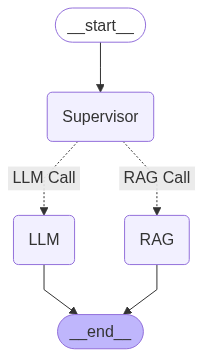

In [73]:
from langgraph.graph import StateGraph, END
workflow=StateGraph(AgentState)

# add nodes:
workflow.add_node("Supervisor", supervisor_fun)
workflow.add_node("RAG", rag_fun)
workflow.add_node("LLM", llm_fun)
workflow.set_entry_point("Supervisor")

# add edges:
workflow.add_conditional_edges("Supervisor",router,
        {
            "RAG Call": "RAG",
            "LLM Call": "LLM",
        })
workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)
workflow.compile()

### Create APP:

In [74]:
app=workflow.compile()

In [75]:
state={"messages": ["Hello"]}
app.invoke(state)

***** Supervisor Node *****
Question:  Hello
Response: Topic='Not Related' Reasoning="The query 'Hello' is a generic greeting and does not contain any information related to US finance."
***** LLM Node *****
Question:  Hello


{'messages': ['Hello', 'Not Related', 'Hello!']}

In [76]:
state={"messages": ["What is the GDP of USA"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the GDP of USA
Response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA, a key economic indicator related to US finances.'
***** LLM Node *****
Question:  What is the GDP of USA


{'messages': ['What is the GDP of USA',
  'USA',
  'I cannot provide the exact, real-time GDP of the USA.  GDP figures are calculated and released periodically by official sources like the Bureau of Economic Analysis (BEA) in the U.S.  These figures are dynamic and change constantly.  To find the most up-to-date information, you should consult the BEA website directly.']}

In [77]:
state={"messages": ["What is the growth of world's most powerful economy?"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the growth of world's most powerful economy?
Response: Topic='USA' Reasoning="The query asks about the growth of the world's most powerful economy, which is generally considered to be the United States' economy."
***** LLM Node *****
Question:  What is the growth of world's most powerful economy?


{'messages': ["What is the growth of world's most powerful economy?",
  'USA',
  "The world's most powerful economy is the United States.  Its growth in recent years has been somewhat variable.  While precise figures fluctuate depending on the reporting agency and the specific metric used (e.g., real GDP growth, nominal GDP growth),  the US economy has experienced periods of relatively strong growth followed by slower periods, including a period of negative growth (a recession) in 2020 due to the COVID-19 pandemic.  Currently (as of late 2023), the US economy is showing signs of slowing growth, with inflation remaining a concern and the Federal Reserve actively working to manage it.  Predicting future growth with certainty is impossible, as it depends on many interconnected factors including global events, domestic policy, and technological advancements."]}

In [78]:
state={"messages": ["What is LLM?"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is LLM?
Response: Topic='Not Related' Reasoning='The query "What is LLM?" is not related to US finance.  LLM refers to Large Language Model, a topic in artificial intelligence.'
***** LLM Node *****
Question:  What is LLM?


{'messages': ['What is LLM?',
  'Not Related',
  "LLM stands for **Large Language Model**.  It's a type of artificial intelligence (AI) that's been trained on massive amounts of text data. This allows it to understand, generate, and translate human language.  Think of it as a sophisticated pattern-matching machine that can predict the next word in a sentence, or even generate entire paragraphs or articles based on a prompt.  Examples of LLMs include GPT-3, LaMDA, and PaLM.  They are used in a wide variety of applications, from chatbots and virtual assistants to language translation and text summarization."]}

In [79]:
state={"messages": ["What is GDP?"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is GDP?
Response: Topic='Not Related' Reasoning='While GDP is a financial indicator, the query does not specify it relates to the USA.'
***** LLM Node *****
Question:  What is GDP?


{'messages': ['What is GDP?',
  'Not Related',
  "GDP, or Gross Domestic Product, is the total monetary or market value of all the finished goods and services produced within a country's borders in a specific time period.  It's usually calculated on an annual or quarterly basis.  Essentially, it's a measure of a country's economic output and is often used as an indicator of its overall economic health.  However, it's important to remember that GDP doesn't capture everything about a country's well-being, such as income inequality or environmental sustainability."]}

In [80]:
state={"messages": ["What is the longest road in USA"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the longest road in USA
Response: Topic='Not Related' Reasoning='The query asks about the longest road in the USA, which is a geographical question, not a financial one.'
***** LLM Node *****
Question:  What is the longest road in USA


{'messages': ['What is the longest road in USA',
  'Not Related',
  'There\'s no single definitive answer to "the longest road in the USA" because it depends on how you define "road."  There\'s no single continuous road stretching thousands of miles.  The term is ambiguous and can refer to:\n\n* **Longest continuous highway:**  This is often cited as the U.S. Route 20, which stretches approximately 3,365 miles across the country. However, even this isn\'t a completely continuous, perfectly straight road – it has many changes in route number and segments.\n\n* **Longest named highway:**  This is difficult to definitively say, as many highways share names across different states.\n\n* **Longest numbered route:** Again, this is ambiguous due to the way routes are numbered and segmented.\n\n\nTherefore, while U.S. Route 20 is frequently cited as the longest, it\'s more accurate to say it\'s *one of* the longest routes, and the title is debatable depending on the criteria used.']}